In [ ]:
# default_exp tiling

# Tiling

> Tiling for both raster and vector data

In [ ]:
#hide
from nbdev.showdoc import *


In [ ]:
#export

from drone_detector.imports import *
from drone_detector.utils import *

In [ ]:
#export

def make_grid(path, gridsize_x:int=640, gridsize_y:int=480, 
              overlap:Tuple[int, int]=(100,100)) -> gpd.GeoDataFrame:
    """Creates a grid template with `gridsize_x` times `gridsize_y` cells, with `overlap` pixels of overlap
    based on geotiff file in `path`. Returns a gpd.GeoDataFrame with `RyyCxx` identifier for each geometry 
    """
    ds = gdal.Open(path)
    ulx, xres, xskew, uly, yskew, yres = ds.GetGeoTransform()
    lrx = ulx + (ds.RasterXSize * xres)
    lry = uly + (ds.RasterYSize * yres)
    # number of output cells is calculated like conv output
    ncols = int(np.floor((np.floor((lrx - ulx) / xres)) - gridsize_x) / (gridsize_x - overlap[0]) + 1)
    nrows = int(np.floor((np.floor((lry - uly) / yres)) - gridsize_y) / (gridsize_y - overlap[1]) + 1)
    polys = []
    names = []
    for col, row in (itertools.product(range(ncols), range(nrows))):
        ytop = lry - row * (yres * (gridsize_y - overlap[1]))
        ybot = ytop - (yres * gridsize_y)
        xleft = ulx + col * (xres * (gridsize_x - overlap[0]))
        xright = xleft + (xres * gridsize_x)
        polys.append(Polygon([(xleft,ytop), (xright,ytop), (xright,ybot), (xleft,ybot)]))
        names.append(f'R{row}C{col}')
    grid = gpd.GeoDataFrame({'cell': names, 'geometry':polys})
    ds = None
    return grid

In [ ]:
# export

class Tiler():
    "Similar functions than ´solaris.tile.raster_tile' but with more recent dependencies"
    def __init__(self, outpath, gridsize_x:int=400, gridsize_y:int=400, 
                 overlap:Tuple[int, int]=(100, 100)):
        store_attr()
        self.grid = None
        if not os.path.exists(outpath): os.makedirs(outpath)
            
        self.raster_path = f'{self.outpath}/raster_tiles'
        self.vector_path = f'{self.outpath}/vector_tiles'
        self.rasterized_vector_path = f'{self.outpath}/rasterized_vector_tiles'
        
    def tile_raster(self, path_to_raster:str) -> None:
        self.grid = make_grid(str(path_to_raster), gridsize_x=self.gridsize_x,
                              gridsize_y=self.gridsize_y, overlap=self.overlap)
        raster = gdal.Open(path_to_raster)
        if not os.path.exists(self.raster_path): os.makedirs(self.raster_path)
        for row in tqdm(self.grid.itertuples()):
            tempraster = gdal.Translate(f'{self.raster_path}/{row.cell}.tif', raster,
                                        projWin=[row.geometry.bounds[0], row.geometry.bounds[3], 
                                                 row.geometry.bounds[2], row.geometry.bounds[1]]
                                       )
            tempraster = None
        return
    
    
    def tile_vector(self, path_to_vector:str) -> None:
        if self.grid is None:
            print('No raster grid specified, use Tiler.tile_raster to determine grid limits')
            return
        
        if not os.path.exists(self.vector_path): os.makedirs(self.vector_path)
        vector = gpd.read_file(path_to_vector)
        # God bless spatial index
        sindex = vector.sindex
        for row in tqdm(self.grid.itertuples()):
            possible_matches_index = list(sindex.intersection(row.geometry.bounds))
            tempvector = vector.iloc[possible_matches_index].copy()
            tempvector = gpd.clip(tempvector, row.geometry, keep_geom_type=True)
            # No annotations -> no shapefile
            if len(tempvector) == 0: continue
            
            # Filter too small geometries TODO
            tempvector.to_file(f'{self.vector_path}/{row.cell}.shp')
        return
    
    def tile_and_rasterize_vector(self, column:str) -> None:
        """Rasterizes vectors based on tiled rasters. 
        Requires that shapefile has numeric data in `column`"""
        if not os.path.exists(self.rasterized_vector_path):
            os.makedirs(self.rasterized_vector_path)
        
        vector_files = [f for f in os.listdir(self.vector_path) if f.endswith('.shp')]
        raster_files = [f'{f[:-4]}.tif' for f in vector_files]
        for r, v in tqdm(zip(raster_files, vector_files)):
            source_raster = gdal.Open(f'{self.raster_path}/{r}', gdal.GA_ReadOnly)
            source_vector = ogr.Open(f'{self.vector_path}/{v}')
            source_vector_layer = source_vector.GetLayer()
            
            output_raster = gdal.GetDriverByName('gtiff').Create(f'{self.rasterized_vector_path}/{r}',
                                                                 source_raster.RasterXSize,
                                                                 source_raster.RasterYSize,
                                                                 1,
                                                                 gdal.GDT_Int16)
            output_raster.SetProjection(source_raster.GetProjectionRef())
            output_raster.SetGeoTransform(source_raster.GetGeoTransform())
            band = output_raster.GetRasterBand(1)
            band.SetNoDataValue(0)
            gdal.RasterizeLayer(output_raster, [1], source_vector_layer, options=[f'ATTRIBUTE={column}'])
            
            band = None
            source_vector = None
            source_raster = None
            output_raster = None        
            
        return 
    
def untile_raster(path_to_targets:str, outfile:str, method:str='first'):
    """Create a single raster file from a directory of predicted rasters, based on the grid generated in 
    `self.tile_raster`"""

    rasters = [f'{path_to_targets}/{f}' for f in os.listdir(path_to_targets) if f.endswith('.tif')]
    
    if method == 'sum': method = copy_sum
    
    files_to_mosaic = []
    
    mosaic = rio.open(rasters[0])
    
    for i in range(1,len(rasters)-1):
        src = rio.open(rasters[i])
        #files_to_mosaic.append(src)
    
        mosaic, out_tfm = rio_merge([mosaic, src], method=method)
    
    out_meta = src.meta.copy()
    out_meta.update({'driver': 'GTiff',
                     'height': mosaic.shape[1],
                     'width': mosaic.shape[2],
                     'transform': out_tfm,
                     'crs': src.crs})
    
    with rio.open(outfile, 'w', **out_meta) as dest: dest.write(mosaic)
    
def copy_sum(merged_data, new_data, merged_mask, new_mask, **kwargs):
    "Useful with prediction data"
    newregion = merged_data + new_data
    np.copyto(merged_data, newregion)    
    
def untile_vector(path_to_targets:str, outpath:str, non_max_suppression_thresh:float=0.0):
    "Create single shapefile from a directory of predicted shapefiles"
    pred_files = [f for f in os.listdir(path_to_targets) if f.endswith('.shp')]
    gdf = None
    for p in tqdm(pred_files):
        temp_gdf = gpd.read_file(f'{path_to_targets}/{p}')
        if gdf is None: gdf = temp_gdf
        else: gdf = gdf.append(temp_gdf)
    print(f'{len(gdf)} polygons before non-max suppression')
    if non_max_suppression_thresh != 0:
        np_bounding_boxes = np.array([b.bounds for b in gdf.geometry])
        idxs = non_max_suppression_fast(np_bounding_boxes, overlap_thresh = non_max_suppression_thresh)
        gdf = gdf.iloc[idxs]
    print(f'{len(gdf)} polygons after non-max suppression')
    gdf.to_file(outpath)
    return


In [ ]:
f = gpd.read_file('example_data/R70C21.shp')
f.head()
f['label_id'] = f.apply(lambda row: 2 if row.label == 'Standing' else 1, axis=1)
f.to_file('example_data/R70C21.shp')

In [ ]:
tiler = Tiler(outpath='example_data/tiles', gridsize_x=120, gridsize_y=120, overlap=(40,40))

In [ ]:
tiler.tile_raster('example_data/R70C21.tif')

0it [00:00, ?it/s]

<AxesSubplot:>

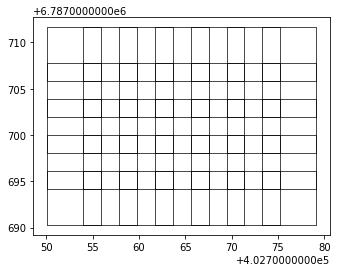

In [ ]:
tiler.grid.plot(facecolor='none', edgecolor='black', lw=0.7)

In [ ]:
tiler.tile_vector('example_data/R70C21.shp')

0it [00:00, ?it/s]

In [ ]:
tiler.tile_and_rasterize_vector(column='label_id')

0it [00:00, ?it/s]

In [ ]:
with rio.open('example_data/tiles/rasterized_vector_tiles/R1C6.tif') as i: im = i.read()

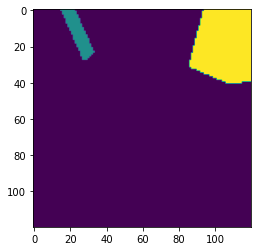

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(im[0])

Grid starts from lower left, so it excludes top and right if full sized tiles can't be extracted.

`untile_raster` can be used to mosaic all patches into one.

In [ ]:
untile_raster('example_data/tiles/rasterized_vector_tiles/', 'example_data/tiles/rasterized_vector_tiles/mosaic.tif')

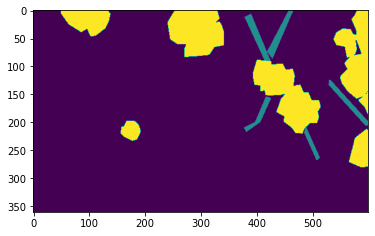

In [ ]:
with rio.open('example_data/tiles/rasterized_vector_tiles/mosaic.tif') as mos: mosaic = mos.read()
plt.imshow(mosaic[0])

In [ ]:
untile_raster('example_data/tiles/rasterized_vector_tiles/', 'example_data/tiles/rasterized_vector_tiles/mosaic.tif',
              method='sum')

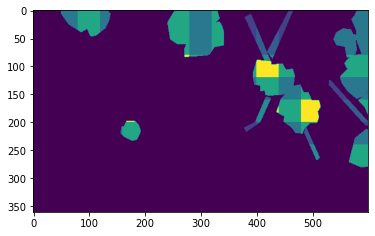

In [ ]:
with rio.open('example_data/tiles/rasterized_vector_tiles/mosaic.tif') as mos: mosaic = mos.read()
plt.imshow(mosaic[0])

In [ ]:
# hide

from nbdev.export import notebook2script
notebook2script()
!nbdev_build_docs

Converted 00_utils.ipynb.
Converted 01_tiling.ipynb.
Converted 02_coordinates.ipynb.
Converted 03_coco.ipynb.
Converted 04_postprocessing.ipynb.
Converted 05_visualizations.ipynb.
Converted 08_predict.ipynb.
Converted 09_augmentations.ipynb.
Converted 10_metrics.ipynb.
Converted 11_data.ipynb.
Converted 12_losses.ipynb.
Converted index.ipynb.
converting: /mnt/d/Users/E1005164/drone_detector/nbs/01_tiling.ipynb
converting /mnt/d/Users/E1005164/drone_detector/nbs/index.ipynb to README.md
